# **UTMobileNet2021 KERAS DL Analiz** 


### Kurulumlar

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!tar xf spark-3.2.1-bin-hadoop3.2.tgz
!pip install -q findspark
!apt-get install openjdk-8-jdk-headless -qq 

In [2]:
!sudo add-apt-repository ppa:webupd8team/java
!sudo apt-get update
!sudo apt-get install oracle-java8-installer

 The Oracle JDK License has changed for releases starting April 16, 2019.

The new Oracle Technology Network License Agreement for Oracle Java SE is substantially different from prior Oracle JDK licenses. The new license permits certain uses, such as personal use and development use, at no cost -- but other uses authorized under prior Oracle JDK licenses may no longer be available. Please review the terms carefully before downloading and using this product. An FAQ is available here: https://www.oracle.com/technetwork/java/javase/overview/oracle-jdk-faqs.html

Oracle Java downloads now require logging in to an Oracle account to download Java updates, like the latest Oracle Java 8u211 / Java SE 8u212. Because of this I cannot update the PPA with the latest Java (and the old links were broken by Oracle).

For this reason, THIS PPA IS DISCONTINUED.

UPDATE:

For Oracle Java 17, see a different PPA -> https://www.linuxuprising.com/2021/09/how-to-install-oracle-java-17-lts-on.html

Old descr

In [3]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop3.2"

In [4]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/UTMobileNet2021_analiz/

Mounted at /content/drive
/content/drive/My Drive/UTMobileNet2021_analiz


In [5]:
import findspark
findspark.init()
from pyspark.sql import SparkSession

In [6]:
spark = SparkSession.builder \
      .master("local") \
      .appName("UTMobileNet2021_proje") \
      .config("spark.executor.memory", "12gb") \
      .getOrCreate()
    
sc = spark.sparkContext

In [7]:
import numpy as np
import pandas as pd
import sklearn as sk
import seaborn as sbn
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras

Öznitelik adlarındaki "." yerine "_" konuldu.

Vector Assembler

MinMaxScaler

Train Test Split %80 - %20 (seed=42)

In [8]:
dataset= pd.read_csv("dataset_v2.csv")

In [9]:
dataset

,Unnamed: 0,frame.len,frame.cap_len,sll.pkttype,sll.hatype,sll.src.eth,sll.unused,ip.len,ip.id,ip.ttl,...,tcp.seq,tcp.ack,tcp.flags.fin,tcp.window_size_value,tcp.checksum,tcp.option_kind,tcp.option_len,tcp.options.timestamp.tsval,tcp.options.timestamp.tsecr,application
0,0,76,76,4,1,3,0,60.0,40299,64.0,...,0.0,0.0,0.0,65535.0,8876,7,9,1.751216e+06,0.000000e+00,0
1,1,76,76,4,1,3,0,60.0,22174,64.0,...,0.0,0.0,0.0,65535.0,8892,7,9,1.751217e+06,0.000000e+00,0
2,4,76,76,4,1,3,0,60.0,29350,64.0,...,0.0,0.0,0.0,65535.0,8876,7,9,1.751218e+06,0.000000e+00,0
3,5,76,76,4,1,3,0,60.0,48386,64.0,...,0.0,0.0,0.0,65535.0,8892,7,9,1.751220e+06,0.000000e+00,0
4,12,76,76,0,1,2,0,60.0,0,86.0,...,0.0,1.0,0.0,27960.0,45042,7,9,4.005977e+09,1.751218e+06,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
634953,680445,68,68,4,1,4,11368,52.0,60821,64.0,...,603.0,3939.0,0.0,386.0,45098,1,0,5.325970e+05,7.630374e+08,13
634954,680446,68,68,4,1,4,56718,52.0,38898,64.0,...,603.0,3940.0,0.0,386.0,45098,1,0,5.325970e+05,3.821468e+08,13
634955,680447,68,68,4,1,4,65352,52.0,54200,64.0,...,603.0,3939.0,0.0,385.0,45098,1,0,5.325970e+05,3.455872e+09,13
634956,686062,91,91,4,1,4,0,75.0,24716,64.0,...,1099.0,4224.0,0.0,394.0,11843,1,0,5.500930e+05,3.873080e+09,13


In [10]:
dataset= dataset.drop(columns= ['Unnamed: 0'])

In [11]:
dataset = spark.createDataFrame(dataset)

In [12]:
dataset = dataset.toDF(*(c.replace('.', '_') for c in dataset.columns))

In [13]:
dataset.drop("application").toPandas().columns

Index(['frame_len', 'frame_cap_len', 'sll_pkttype', 'sll_hatype',
       'sll_src_eth', 'sll_unused', 'ip_len', 'ip_id', 'ip_ttl', 'ip_checksum',
       'ip_src', 'ip_dst', 'tcp_hdr_len', 'tcp_len', 'tcp_srcport',
       'tcp_dstport', 'tcp_seq', 'tcp_ack', 'tcp_flags_fin',
       'tcp_window_size_value', 'tcp_checksum', 'tcp_option_kind',
       'tcp_option_len', 'tcp_options_timestamp_tsval',
       'tcp_options_timestamp_tsecr'],
      dtype='object')

In [14]:
from pyspark.ml.feature import VectorAssembler

assemblerInput = ['frame_len', 'frame_cap_len', 'sll_pkttype', 'sll_hatype',
       'sll_src_eth', 'sll_unused', 'ip_len', 'ip_id', 'ip_ttl', 'ip_checksum',
       'ip_src', 'ip_dst', 'tcp_hdr_len', 'tcp_len', 'tcp_srcport',
       'tcp_dstport', 'tcp_seq', 'tcp_ack', 'tcp_flags_fin',
       'tcp_window_size_value', 'tcp_checksum', 'tcp_option_kind',
       'tcp_option_len', 'tcp_options_timestamp_tsval',
       'tcp_options_timestamp_tsecr']

assembler = VectorAssembler(inputCols= assemblerInput,  outputCol='vectorizedFeatures')

vectorized_dataset = assembler.transform(dataset)

In [15]:
from pyspark.ml.feature import MinMaxScaler

scaler = MinMaxScaler(inputCol='vectorizedFeatures', outputCol="scaledFeatures")
scalerModel = scaler.fit(vectorized_dataset)
scaled_Data = scalerModel.transform(vectorized_dataset)

In [16]:
dataset=scaled_Data.select("scaledFeatures", 'application')

In [17]:
train_data,test_data = dataset.randomSplit([0.8,0.2], seed=42)

## DNN

1. One Hot Encoder

2. Reshape



In [18]:
xtrain_array = np.asarray(train_data.select('scaledFeatures').collect())
xtest_array = np.asarray(test_data.select('scaledFeatures').collect())
ytrain_array = np.asarray(train_data.select('application').collect())
ytest_array = np.asarray(test_data.select('application').collect())

In [19]:
import tensorflow.keras.utils as u
ytrain_OHE = u.to_categorical(ytrain_array)
ytest_OHE = u.to_categorical(ytest_array)

In [20]:
print(ytrain_OHE.shape)
print(ytest_OHE.shape)
print(xtrain_array.shape)
print(xtest_array.shape)

(508051, 14)
(126907, 14)
(508051, 1, 25)
(126907, 1, 25)


In [21]:
xtrain_array =xtrain_array.reshape(-1,25)
xtest_array = xtest_array.reshape(-1,25)

In [22]:
print(ytrain_OHE.shape)
print(ytest_OHE.shape)
print(xtrain_array.shape)
print(xtest_array.shape)

(508051, 14)
(126907, 14)
(508051, 25)
(126907, 25)


In [23]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import models,layers
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [24]:
import os
os.environ['PYTHONHASHSEED']=str(42)
tf.random.set_seed(42)
np.random.seed(42)

In [25]:
model6 = Sequential()

model6.add(Dense(128,activation = "relu"))

model6.add(Dense(64,activation = "relu"))

model6.add(Dense(64,activation = "relu"))

model6.add(Dense(14,activation = "softmax"))

model6.compile(loss="categorical_crossentropy",optimizer = "adam")

earlyStopping = EarlyStopping(monitor="val_loss",mode="min",verbose=1,patience=25) 

model6.fit(xtrain_array, ytrain_OHE, epochs=30, 
          validation_data=(xtest_array, ytest_OHE),verbose=1, callbacks=[earlyStopping])

Epoch 1/30
15877/15877 [==============================] - 39s 2ms/step - loss: 0.1982 - val_loss: 0.0907
Epoch 2/30
15877/15877 [==============================] - 37s 2ms/step - loss: 0.0633 - val_loss: 0.0540
Epoch 3/30
15877/15877 [==============================] - 38s 2ms/step - loss: 0.0453 - val_loss: 0.0333
Epoch 4/30
15877/15877 [==============================] - 35s 2ms/step - loss: 0.0348 - val_loss: 0.0287
Epoch 5/30
15877/15877 [==============================] - 35s 2ms/step - loss: 0.0279 - val_loss: 0.0314
Epoch 6/30
15877/15877 [==============================] - 34s 2ms/step - loss: 0.0238 - val_loss: 0.0248
Epoch 7/30
15877/15877 [==============================] - 36s 2ms/step - loss: 0.0222 - val_loss: 0.0237
Epoch 8/30
15877/15877 [==============================] - 36s 2ms/step - loss: 0.0201 - val_loss: 0.0188
Epoch 9/30
15877/15877 [==============================] - 36s 2ms/step - loss: 0.0187 - val_loss: 0.0183
Epoch 10/30
15877/15877 [==============================

In [26]:
model6.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               3328      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 14)                910       
                                                                 
Total params: 16,654
Trainable params: 16,654
Non-trainable params: 0
_________________________________________________________________


Text(0.5, 1.0, 'Deep Neural Network (DNN)')

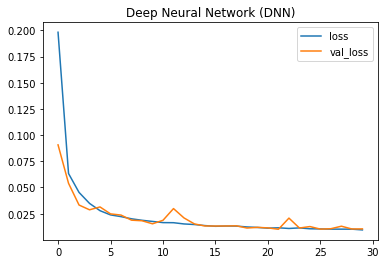

In [27]:
kayipDf6 = pd.DataFrame(model6.history.history)
ax6 = kayipDf6.plot()
ax6.set_title("Deep Neural Network (DNN)")

In [28]:
y_pred6 = model6.predict(xtest_array)
y_pred6=np.argmax(y_pred6, axis=1)
ytest_OHE =np.argmax(ytest_OHE, axis=1)

In [29]:
from sklearn.metrics import classification_report, confusion_matrix

target_names = ["Facebook","Gmail","Google Drive","Google Maps","Hangouts",
                "Hulu", "Instagram","Messenger","Netflix","Pinterest","Reddit",
                "Spotify", "Twitter","Youtube"]
print(classification_report(ytest_OHE,y_pred6, target_names=target_names))

              precision    recall  f1-score   support

    Facebook       0.99      0.99      0.99      4262
       Gmail       0.96      0.99      0.97       850
Google Drive       1.00      1.00      1.00     43524
 Google Maps       1.00      1.00      1.00      8349
    Hangouts       0.89      0.93      0.91       382
        Hulu       1.00      1.00      1.00     17032
   Instagram       1.00      1.00      1.00      9363
   Messenger       0.85      0.86      0.85       262
     Netflix       1.00      1.00      1.00     11780
   Pinterest       1.00      1.00      1.00     11816
      Reddit       1.00      1.00      1.00      7795
     Spotify       1.00      0.99      1.00      6753
     Twitter       1.00      1.00      1.00      4666
     Youtube       0.93      0.74      0.82        73

    accuracy                           1.00    126907
   macro avg       0.97      0.96      0.97    126907
weighted avg       1.00      1.00      1.00    126907



In [30]:
from sklearn.metrics import accuracy_score, f1_score, recall_score,precision_score
print ("accuracy: ",accuracy_score(ytest_array, y_pred6))
print ("f1-score: ",f1_score(ytest_array, y_pred6, average="weighted"))
print ("recall: ", recall_score(ytest_array, y_pred6,average="weighted"))
print ("precision: ", precision_score(ytest_array, y_pred6, average="weighted"))

accuracy:  0.9972893536211557
f1-score:  0.9972880916585578
recall:  0.9972893536211557
precision:  0.9973061548695716


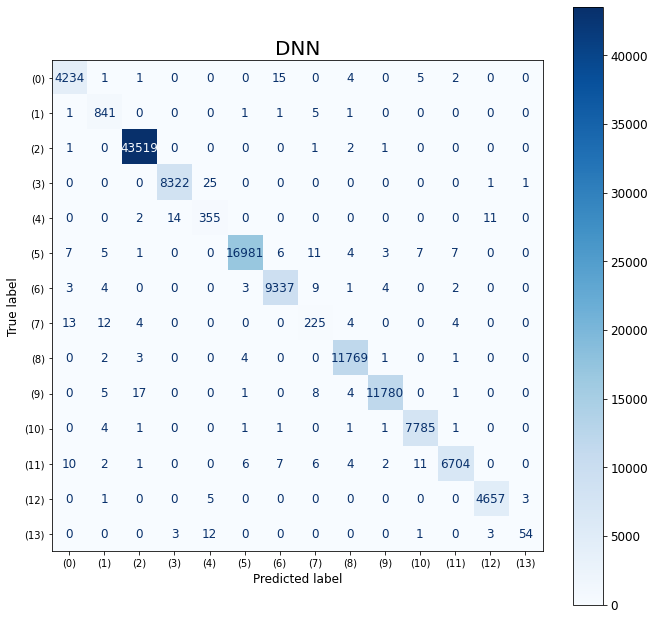

In [31]:
from sklearn.metrics import ConfusionMatrixDisplay

cm6 = confusion_matrix(ytest_array,y_pred6)

target_names =["({})".format(i) for i in range(14)]
cmp = ConfusionMatrixDisplay(cm6,display_labels=target_names)
fig, ax, = plt.subplots(figsize=(11,11))
ax.set_title('DNN', fontdict = {'fontsize': 20})
ax.set_xlabel("Predicted labels", fontdict = {'fontsize': 12})
ax.set_ylabel('True labels', fontdict = {'fontsize': 12})
plt.rcParams.update({'font.size': 12})
cmp.plot(ax=ax, cmap=plt.cm.Blues)
plt.show()

## LSTM

1. One Hot Encoder

In [32]:
xtrain_array = np.asarray(train_data.select('scaledFeatures').collect())
xtest_array = np.asarray(test_data.select('scaledFeatures').collect())
ytrain_array = np.asarray(train_data.select('application').collect())
ytest_array = np.asarray(test_data.select('application').collect())

In [33]:
import tensorflow.keras.utils as u
ytrain_OHE = u.to_categorical(ytrain_array)
ytest_OHE = u.to_categorical(ytest_array)

In [34]:
print(ytrain_OHE.shape)
print(ytest_OHE.shape)
print(xtrain_array.shape)
print(xtest_array.shape)

(508051, 14)
(126907, 14)
(508051, 1, 25)
(126907, 1, 25)


In [35]:
import os
os.environ['PYTHONHASHSEED']=str(42)
tf.random.set_seed(42)
np.random.seed(42)

In [36]:
model7 = Sequential()

model7.add(layers.LSTM(64, activation = "relu", return_sequences = True))

model7.add(layers.LSTM(64, activation = "relu", return_sequences = False))


model7.add(Dense(14,activation = "softmax"))

model7.compile(loss="categorical_crossentropy",optimizer = "adam")

earlyStopping = EarlyStopping(monitor="val_loss",mode="min",verbose=1,patience=25)

model7.fit(xtrain_array, ytrain_OHE, epochs=30, 
          validation_data=(xtest_array, ytest_OHE),verbose=1, callbacks=[earlyStopping])

Epoch 1/30
15877/15877 [==============================] - 74s 5ms/step - loss: 0.3769 - val_loss: 0.1964
Epoch 2/30
15877/15877 [==============================] - 70s 4ms/step - loss: 0.1381 - val_loss: 0.1050
Epoch 3/30
15877/15877 [==============================] - 73s 5ms/step - loss: 0.0906 - val_loss: 0.0733
Epoch 4/30
15877/15877 [==============================] - 73s 5ms/step - loss: 0.0676 - val_loss: 0.0564
Epoch 5/30
15877/15877 [==============================] - 73s 5ms/step - loss: 0.0536 - val_loss: 0.0443
Epoch 6/30
15877/15877 [==============================] - 67s 4ms/step - loss: 0.0446 - val_loss: 0.0456
Epoch 7/30
15877/15877 [==============================] - 75s 5ms/step - loss: 0.0373 - val_loss: 0.0332
Epoch 8/30
15877/15877 [==============================] - 78s 5ms/step - loss: 0.0323 - val_loss: 0.0340
Epoch 9/30
15877/15877 [==============================] - 73s 5ms/step - loss: 0.0283 - val_loss: 0.0307
Epoch 10/30
15877/15877 [==============================

In [37]:
model7.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 64)             23040     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense_4 (Dense)             (None, 14)                910       
                                                                 
Total params: 56,974
Trainable params: 56,974
Non-trainable params: 0
_________________________________________________________________


Text(0.5, 1.0, 'Long Short-Term Memory (LSTM)')

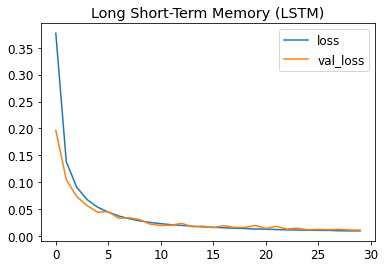

In [38]:
kayipDf7 = pd.DataFrame(model7.history.history)
ax7 = kayipDf7.plot()
ax7.set_title("Long Short-Term Memory (LSTM)")

In [39]:
y_pred7 = model7.predict(xtest_array)
y_pred7=np.argmax(y_pred7, axis=1)
ytest_OHE =np.argmax(ytest_OHE, axis=1)

In [40]:
from sklearn.metrics import classification_report, confusion_matrix

target_names = ["Facebook","Gmail","Google Drive","Google Maps","Hangouts",
                "Hulu", "Instagram","Messenger","Netflix","Pinterest","Reddit",
                "Spotify", "Twitter","Youtube"]
print(classification_report(ytest_OHE,y_pred7, target_names=target_names))

              precision    recall  f1-score   support

    Facebook       0.99      0.99      0.99      4262
       Gmail       0.94      0.99      0.97       850
Google Drive       1.00      1.00      1.00     43524
 Google Maps       0.99      1.00      1.00      8349
    Hangouts       0.89      0.91      0.90       382
        Hulu       1.00      1.00      1.00     17032
   Instagram       1.00      1.00      1.00      9363
   Messenger       0.86      0.85      0.85       262
     Netflix       1.00      1.00      1.00     11780
   Pinterest       1.00      1.00      1.00     11816
      Reddit       1.00      1.00      1.00      7795
     Spotify       0.99      0.99      0.99      6753
     Twitter       1.00      1.00      1.00      4666
     Youtube       0.89      0.64      0.75        73

    accuracy                           1.00    126907
   macro avg       0.97      0.95      0.96    126907
weighted avg       1.00      1.00      1.00    126907



In [41]:
from sklearn.metrics import accuracy_score, f1_score, recall_score,precision_score
print ("accuracy: ",accuracy_score(ytest_array, y_pred7))
print ("f1-score: ",f1_score(ytest_array, y_pred7, average="weighted"))
print ("recall: ", recall_score(ytest_array, y_pred7,average="weighted"))
print ("precision: ", precision_score(ytest_array, y_pred7, average="weighted"))

accuracy:  0.9968480856059949
f1-score:  0.9968351801464574
recall:  0.9968480856059949
precision:  0.9968541507857219


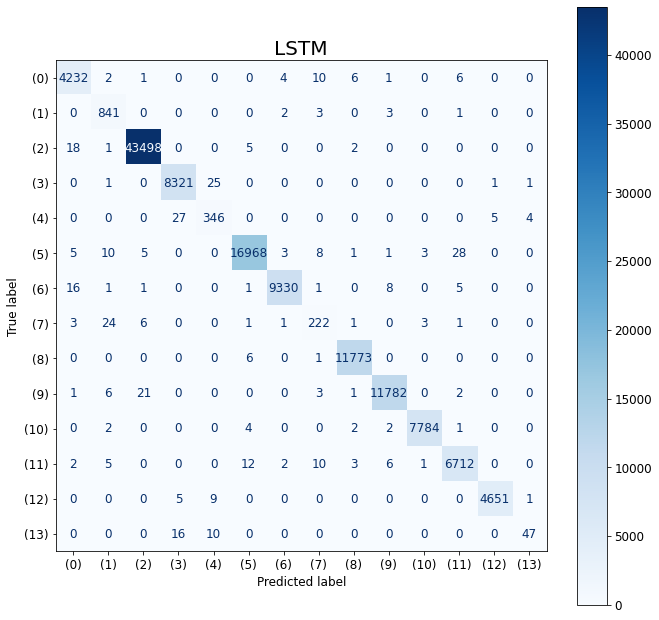

In [42]:
from sklearn.metrics import ConfusionMatrixDisplay

cm7 = confusion_matrix(ytest_array,y_pred7)

target_names =["({})".format(i) for i in range(14)]
cmp = ConfusionMatrixDisplay(cm7,display_labels=target_names)
fig, ax, = plt.subplots(figsize=(11,11))
ax.set_title('LSTM', fontdict = {'fontsize': 20})
ax.set_xlabel("Predicted labels", fontdict = {'fontsize': 12})
ax.set_ylabel('True labels', fontdict = {'fontsize': 12})
plt.rcParams.update({'font.size': 12})
cmp.plot(ax=ax, cmap=plt.cm.Blues)
plt.show()

## CNN -1D

1. One Hot Encoder

2. Reshape

In [43]:
xtrain_array = np.asarray(train_data.select('scaledFeatures').collect())
xtest_array = np.asarray(test_data.select('scaledFeatures').collect())
ytrain_array = np.asarray(train_data.select('application').collect())
ytest_array = np.asarray(test_data.select('application').collect())

In [44]:
import tensorflow.keras.utils as u
ytrain_OHE = u.to_categorical(ytrain_array)
ytest_OHE = u.to_categorical(ytest_array)

In [45]:
print(ytrain_OHE.shape)
print(ytest_OHE.shape)
print(xtrain_array.shape)
print(xtest_array.shape)

(508051, 14)
(126907, 14)
(508051, 1, 25)
(126907, 1, 25)


In [50]:
xtrain_array =xtrain_array.reshape(-1,25,1)
xtest_array = xtest_array.reshape(-1,25,1)

In [51]:
import os
os.environ['PYTHONHASHSEED']=str(42)
tf.random.set_seed(42)
np.random.seed(42)

In [52]:
from sklearn import metrics
model8 = Sequential()
model8.add(layers.Conv1D(64,2, activation="relu", input_shape=(25,1)))
model8.add(layers.MaxPooling1D(2))
model8.add(layers.Conv1D(64,2, activation="relu"))
model8.add(layers.MaxPooling1D(2))
model8.add(layers.Conv1D(128,2, activation="relu"))
model8.add(layers.Flatten())
model8.add(Dense(128, activation="relu"))
model8.add(Dense(14, activation = 'softmax'))
model8.compile(loss = 'categorical_crossentropy', optimizer = "adam" )


model8.fit(xtrain_array, ytrain_OHE, epochs=30,verbose=1, validation_data=(xtest_array, ytest_OHE))

Epoch 1/30
15877/15877 [==============================] - 128s 8ms/step - loss: 0.1677 - val_loss: 0.0604
Epoch 2/30
15877/15877 [==============================] - 114s 7ms/step - loss: 0.0486 - val_loss: 0.0480
Epoch 3/30
15877/15877 [==============================] - 114s 7ms/step - loss: 0.0332 - val_loss: 0.0258
Epoch 4/30
15877/15877 [==============================] - 107s 7ms/step - loss: 0.0255 - val_loss: 0.0223
Epoch 5/30
15877/15877 [==============================] - 108s 7ms/step - loss: 0.0215 - val_loss: 0.0157
Epoch 6/30
15877/15877 [==============================] - 104s 7ms/step - loss: 0.0180 - val_loss: 0.0326
Epoch 7/30
15877/15877 [==============================] - 113s 7ms/step - loss: 0.0168 - val_loss: 0.0154
Epoch 8/30
15877/15877 [==============================] - 108s 7ms/step - loss: 0.0151 - val_loss: 0.0139
Epoch 9/30
15877/15877 [==============================] - 100s 6ms/step - loss: 0.0138 - val_loss: 0.0150
Epoch 10/30
15877/15877 [=====================

In [53]:
model8.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 24, 64)            192       
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 12, 64)           0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 11, 64)            8256      
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 5, 64)            0         
 1D)                                                             
                                                                 
 conv1d_6 (Conv1D)           (None, 4, 128)            16512     
                                                                 
 flatten (Flatten)           (None, 512)              

Text(0.5, 1.0, 'Convolutional Neural Network (CNN-1D)')

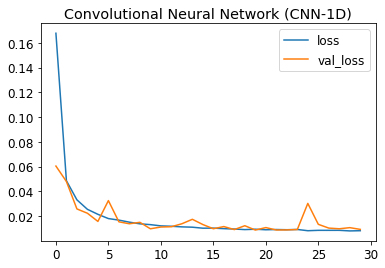

In [54]:
kayipDf8 = pd.DataFrame(model8.history.history)
ax8 = kayipDf8.plot()
ax8.set_title("Convolutional Neural Network (CNN-1D)")

In [55]:
y_pred8 = model8.predict(xtest_array)
y_pred8=np.argmax(y_pred8, axis=1)
ytest_OHE =np.argmax(ytest_OHE, axis=1)

In [56]:
from sklearn.metrics import classification_report, confusion_matrix

target_names = ["Facebook","Gmail","Google Drive","Google Maps","Hangouts",
                "Hulu", "Instagram","Messenger","Netflix","Pinterest","Reddit",
                "Spotify", "Twitter","Youtube"]
print(classification_report(ytest_OHE,y_pred8, target_names=target_names))

              precision    recall  f1-score   support

    Facebook       0.99      0.99      0.99      4262
       Gmail       0.97      1.00      0.98       850
Google Drive       1.00      1.00      1.00     43524
 Google Maps       1.00      1.00      1.00      8349
    Hangouts       0.93      0.95      0.94       382
        Hulu       1.00      1.00      1.00     17032
   Instagram       1.00      0.99      1.00      9363
   Messenger       0.87      0.87      0.87       262
     Netflix       1.00      1.00      1.00     11780
   Pinterest       1.00      1.00      1.00     11816
      Reddit       1.00      1.00      1.00      7795
     Spotify       1.00      1.00      1.00      6753
     Twitter       1.00      1.00      1.00      4666
     Youtube       0.90      0.89      0.90        73

    accuracy                           1.00    126907
   macro avg       0.97      0.98      0.98    126907
weighted avg       1.00      1.00      1.00    126907



In [57]:
from sklearn.metrics import accuracy_score, f1_score, recall_score,precision_score
print ("accuracy: ",accuracy_score(ytest_array, y_pred8))
print ("f1-score: ",f1_score(ytest_array, y_pred8, average="weighted"))
print ("recall: ", recall_score(ytest_array, y_pred8,average="weighted"))
print ("precision: ", precision_score(ytest_array, y_pred8, average="weighted"))

accuracy:  0.9976833429204063
f1-score:  0.9976863621952616
recall:  0.9976833429204063
precision:  0.9976934910708104


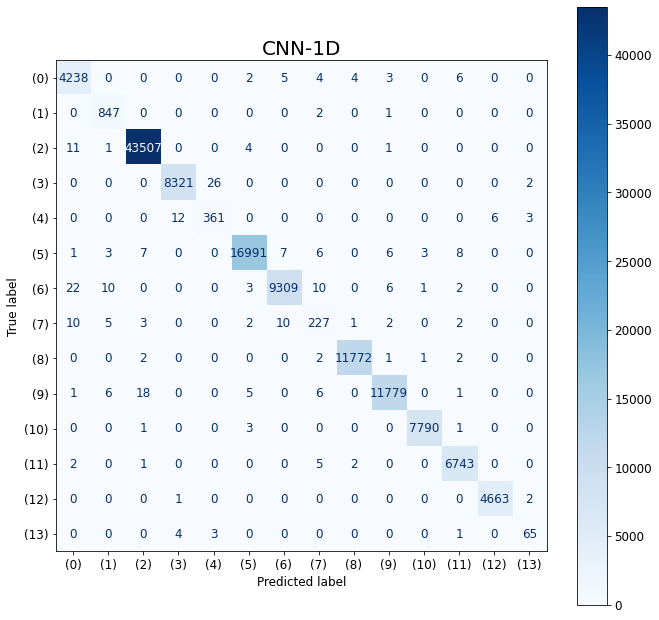

In [58]:
from sklearn.metrics import ConfusionMatrixDisplay

cm8 = confusion_matrix(ytest_array,y_pred8)

target_names =["({})".format(i) for i in range(14)]
cmp = ConfusionMatrixDisplay(cm8,display_labels=target_names)
fig, ax, = plt.subplots(figsize=(11,11))
ax.set_title('CNN-1D', fontdict = {'fontsize': 20})
ax.set_xlabel("Predicted labels", fontdict = {'fontsize': 12})
ax.set_ylabel('True labels', fontdict = {'fontsize': 12})
plt.rcParams.update({'font.size': 12})
cmp.plot(ax=ax, cmap=plt.cm.Blues)
plt.show()

## GRU

1. One Hot Encoder



In [59]:
xtrain_array = np.asarray(train_data.select('scaledFeatures').collect())
xtest_array = np.asarray(test_data.select('scaledFeatures').collect())
ytrain_array = np.asarray(train_data.select('application').collect())
ytest_array = np.asarray(test_data.select('application').collect())

In [60]:
import tensorflow.keras.utils as u
ytrain_OHE = u.to_categorical(ytrain_array)
ytest_OHE = u.to_categorical(ytest_array)

In [61]:
print(ytrain_OHE.shape)
print(ytest_OHE.shape)
print(xtrain_array.shape)
print(xtest_array.shape)

(508051, 14)
(126907, 14)
(508051, 1, 25)
(126907, 1, 25)


In [62]:
import os
os.environ['PYTHONHASHSEED']=str(42)
tf.random.set_seed(42)
np.random.seed(42)

In [63]:
model9 = Sequential()

model9.add(layers.GRU(40, activation = "relu", return_sequences = True))

model9.add(layers.GRU(16, activation = "relu", return_sequences = False))

model9.add(Dense(14,activation = "softmax"))

model9.compile(loss="categorical_crossentropy",optimizer = "adam")

earlyStopping = EarlyStopping(monitor="val_loss",mode="min",verbose=1,patience=25)

model9.fit(xtrain_array, ytrain_OHE, epochs=30, 
          validation_data=(xtest_array, ytest_OHE),verbose=1, callbacks=[earlyStopping])

Epoch 1/30
15877/15877 [==============================] - 64s 4ms/step - loss: 0.4399 - val_loss: 0.2459
Epoch 2/30
15877/15877 [==============================] - 66s 4ms/step - loss: 0.2009 - val_loss: 0.1653
Epoch 3/30
15877/15877 [==============================] - 64s 4ms/step - loss: 0.1509 - val_loss: 0.1338
Epoch 4/30
15877/15877 [==============================] - 61s 4ms/step - loss: 0.1244 - val_loss: 0.1270
Epoch 5/30
15877/15877 [==============================] - 65s 4ms/step - loss: 0.1055 - val_loss: 0.0933
Epoch 6/30
15877/15877 [==============================] - 60s 4ms/step - loss: 0.0918 - val_loss: 0.0869
Epoch 7/30
15877/15877 [==============================] - 59s 4ms/step - loss: 0.0815 - val_loss: 0.0757
Epoch 8/30
15877/15877 [==============================] - 63s 4ms/step - loss: 0.0739 - val_loss: 0.0841
Epoch 9/30
15877/15877 [==============================] - 62s 4ms/step - loss: 0.0678 - val_loss: 0.0622
Epoch 10/30
15877/15877 [==============================

In [64]:
model9.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 1, 40)             8040      
                                                                 
 gru_1 (GRU)                 (None, 16)                2784      
                                                                 
 dense_7 (Dense)             (None, 14)                238       
                                                                 
Total params: 11,062
Trainable params: 11,062
Non-trainable params: 0
_________________________________________________________________


Text(0.5, 1.0, 'Gated Recurrent Units (GRU)')

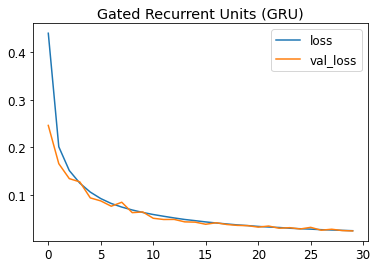

In [65]:
kayipDf9 = pd.DataFrame(model9.history.history)
ax9 = kayipDf9.plot()
ax9.set_title("Gated Recurrent Units (GRU)")

In [66]:
y_pred9 = model9.predict(xtest_array)
y_pred9=np.argmax(y_pred9, axis=1)
ytest_OHE =np.argmax(ytest_OHE, axis=1)

In [67]:
from sklearn.metrics import classification_report, confusion_matrix

target_names = ["Facebook","Gmail","Google Drive","Google Maps","Hangouts",
                "Hulu", "Instagram","Messenger","Netflix","Pinterest","Reddit",
                "Spotify", "Twitter","Youtube"]
print(classification_report(ytest_OHE,y_pred9, target_names=target_names))

              precision    recall  f1-score   support

    Facebook       0.98      0.99      0.99      4262
       Gmail       0.92      0.97      0.95       850
Google Drive       1.00      1.00      1.00     43524
 Google Maps       0.99      0.99      0.99      8349
    Hangouts       0.80      0.83      0.82       382
        Hulu       1.00      0.99      0.99     17032
   Instagram       0.99      0.99      0.99      9363
   Messenger       0.73      0.65      0.68       262
     Netflix       1.00      1.00      1.00     11780
   Pinterest       0.99      0.99      0.99     11816
      Reddit       1.00      1.00      1.00      7795
     Spotify       0.98      0.99      0.99      6753
     Twitter       0.99      1.00      1.00      4666
     Youtube       0.86      0.16      0.28        73

    accuracy                           0.99    126907
   macro avg       0.95      0.90      0.90    126907
weighted avg       0.99      0.99      0.99    126907



In [68]:
from sklearn.metrics import accuracy_score, f1_score, recall_score,precision_score
print ("accuracy: ",accuracy_score(ytest_array, y_pred9))
print ("f1-score: ",f1_score(ytest_array, y_pred9, average="weighted"))
print ("recall: ", recall_score(ytest_array, y_pred9,average="weighted"))
print ("precision: ", precision_score(ytest_array, y_pred9, average="weighted"))

accuracy:  0.9935543350642596
f1-score:  0.9933703620453352
recall:  0.9935543350642596
precision:  0.9934872435772126


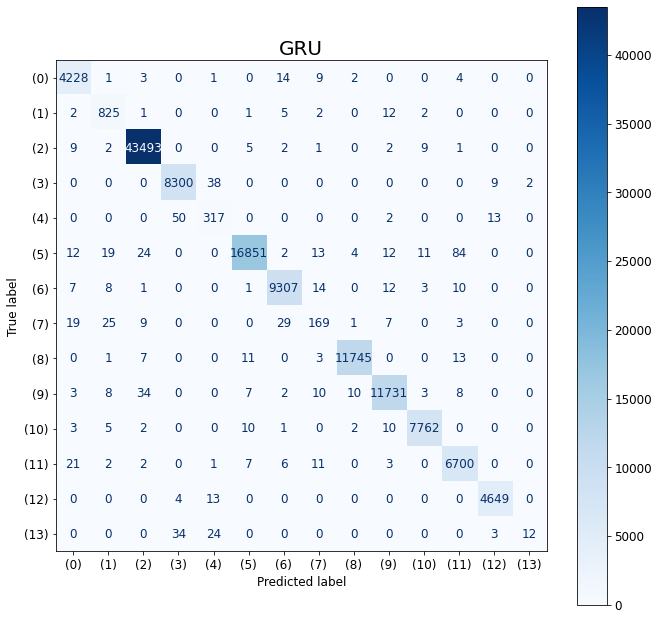

In [69]:
from sklearn.metrics import ConfusionMatrixDisplay

cm9 = confusion_matrix(ytest_array,y_pred9)

target_names =["({})".format(i) for i in range(14)]
cmp = ConfusionMatrixDisplay(cm9,display_labels=target_names)
fig, ax, = plt.subplots(figsize=(11,11))
ax.set_title('GRU', fontdict = {'fontsize': 20})
ax.set_xlabel("Predicted labels", fontdict = {'fontsize': 12})
ax.set_ylabel('True labels', fontdict = {'fontsize': 12})
plt.rcParams.update({'font.size': 12})
cmp.plot(ax=ax, cmap=plt.cm.Blues)
plt.show()

## 10: CNN-LSTM

In [72]:
xtrain_array = np.asarray(train_data.select('scaledFeatures').collect())
xtest_array = np.asarray(test_data.select('scaledFeatures').collect())
ytrain_array = np.asarray(train_data.select('application').collect())
ytest_array = np.asarray(test_data.select('application').collect())

In [73]:
import tensorflow.keras.utils as u
ytrain_OHE = u.to_categorical(ytrain_array)
ytest_OHE = u.to_categorical(ytest_array)

In [74]:
print(ytrain_OHE.shape)
print(ytest_OHE.shape)
print(xtrain_array.shape)
print(xtest_array.shape)

(508051, 14)
(126907, 14)
(508051, 1, 25)
(126907, 1, 25)


In [75]:
xtrain_array =xtrain_array.reshape(-1,25,1)
xtest_array = xtest_array.reshape(-1,25,1)

In [76]:
import os
os.environ['PYTHONHASHSEED']=str(42)
tf.random.set_seed(42)
np.random.seed(42)

In [77]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import models,layers
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [78]:
model10 = Sequential()
model10.add(layers.Conv1D(128, 2,activation="relu", input_shape=(25,1)))
model10.add(layers.MaxPooling1D(2))
model10.add(layers.Conv1D(64, 2, activation="relu"))
model10.add(layers.MaxPooling1D(2))
model10.add(layers.LSTM(128, activation = "relu", return_sequences = True))
model10.add(layers.LSTM(64, activation = "relu", return_sequences = False))
model10.add(layers.Flatten())
model10.add(Dense(128, activation="relu"))
model10.add(Dense(14, activation = 'softmax'))
model10.compile(loss = 'categorical_crossentropy', optimizer = "adam" )
earlyStopping = EarlyStopping(monitor="val_loss",mode="min",verbose=1,patience=25)

model10.fit(xtrain_array, ytrain_OHE, epochs=30, 
          validation_data=(xtest_array, ytest_OHE),verbose=1, callbacks=[earlyStopping])

Epoch 1/30
15877/15877 [==============================] - 299s 19ms/step - loss: 0.2666 - val_loss: 0.0772
Epoch 2/30
15877/15877 [==============================] - 288s 18ms/step - loss: 0.0599 - val_loss: 0.0835
Epoch 3/30
15877/15877 [==============================] - 287s 18ms/step - loss: 0.0400 - val_loss: 0.0268
Epoch 4/30
15877/15877 [==============================] - 289s 18ms/step - loss: 0.0320 - val_loss: 0.0209
Epoch 5/30
15877/15877 [==============================] - 289s 18ms/step - loss: 0.0271 - val_loss: 0.0215
Epoch 6/30
15877/15877 [==============================] - 290s 18ms/step - loss: 0.0239 - val_loss: 0.1130
Epoch 7/30
15877/15877 [==============================] - 290s 18ms/step - loss: 0.0217 - val_loss: 0.0475
Epoch 8/30
15877/15877 [==============================] - 291s 18ms/step - loss: 0.0198 - val_loss: 0.0186
Epoch 9/30
15877/15877 [==============================] - 291s 18ms/step - loss: 0.0186 - val_loss: 0.0169
Epoch 10/30
15877/15877 [============

In [79]:
model10.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_7 (Conv1D)           (None, 24, 128)           384       
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 12, 128)          0         
 1D)                                                             
                                                                 
 conv1d_8 (Conv1D)           (None, 11, 64)            16448     
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 5, 64)            0         
 1D)                                                             
                                                                 
 lstm_2 (LSTM)               (None, 5, 128)            98816     
                                                                 
 lstm_3 (LSTM)               (None, 64)               

Text(0.5, 1.0, 'CNN-LSTM')

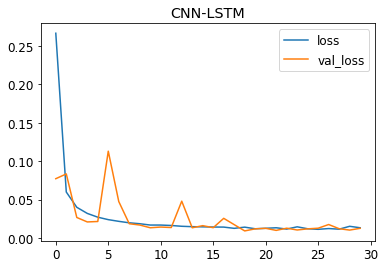

In [80]:
kayipDf10 = pd.DataFrame(model10.history.history)
ax10 = kayipDf10.plot()
ax10.set_title("CNN-LSTM")

In [81]:
y_pred10 = model10.predict(xtest_array)
y_pred10=np.argmax(y_pred10, axis=1)
ytest_OHE =np.argmax(ytest_OHE, axis=1)

In [82]:
from sklearn.metrics import classification_report, confusion_matrix

target_names = ["Facebook","Gmail","Google Drive","Google Maps","Hangouts",
                "Hulu", "Instagram","Messenger","Netflix","Pinterest","Reddit",
                "Spotify", "Twitter","Youtube"]
print(classification_report(ytest_OHE,y_pred10, target_names=target_names))

              precision    recall  f1-score   support

    Facebook       0.99      0.99      0.99      4262
       Gmail       0.96      0.99      0.97       850
Google Drive       1.00      1.00      1.00     43524
 Google Maps       1.00      1.00      1.00      8349
    Hangouts       0.89      0.90      0.90       382
        Hulu       1.00      1.00      1.00     17032
   Instagram       1.00      0.99      1.00      9363
   Messenger       0.81      0.83      0.82       262
     Netflix       1.00      1.00      1.00     11780
   Pinterest       1.00      1.00      1.00     11816
      Reddit       1.00      1.00      1.00      7795
     Spotify       0.99      1.00      1.00      6753
     Twitter       1.00      1.00      1.00      4666
     Youtube       0.73      0.71      0.72        73

    accuracy                           1.00    126907
   macro avg       0.95      0.96      0.96    126907
weighted avg       1.00      1.00      1.00    126907



In [83]:
from sklearn.metrics import accuracy_score, f1_score, recall_score,precision_score
print ("accuracy: ",accuracy_score(ytest_array, y_pred10))
print ("f1-score: ",f1_score(ytest_array, y_pred10, average="weighted"))
print ("recall: ", recall_score(ytest_array, y_pred10,average="weighted"))
print ("precision: ", precision_score(ytest_array, y_pred10, average="weighted"))

accuracy:  0.9967220090302348
f1-score:  0.9967280738510398
recall:  0.9967220090302348
precision:  0.9967400694483284


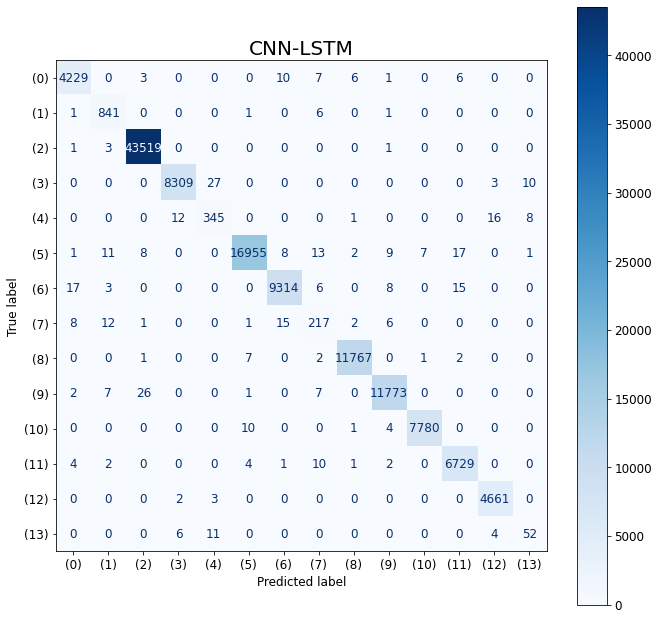

In [86]:
from sklearn.metrics import ConfusionMatrixDisplay

cm10 = confusion_matrix(ytest_array,y_pred10)

target_names =["({})".format(i) for i in range(14)]
cmp = ConfusionMatrixDisplay(cm10,display_labels=target_names)
fig, ax, = plt.subplots(figsize=(11,11))
ax.set_title('CNN-LSTM', fontdict = {'fontsize': 20})
ax.set_xlabel("Predicted labels", fontdict = {'fontsize': 12})
ax.set_ylabel('True labels', fontdict = {'fontsize': 12})
plt.rcParams.update({'font.size': 12})
cmp.plot(ax=ax, cmap=plt.cm.Blues)
plt.show()